<a href="https://colab.research.google.com/github/Kwangbin/finance/blob/main/3_Bankruptcy_Prediction_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#기업의 부도예측

In [1]:
# 패키지 설치 : optbinning
!pip install optbinning

     |████████████████████████████████| 195 kB 7.4 MB/s 
     |████████████████████████████████| 178 kB 40.1 MB/s 
     |████████████████████████████████| 28.5 MB 49 kB/s 
     |████████████████████████████████| 14.4 MB 98 kB/s 
  Created wheel for pympler: filename=Pympler-0.9-py3-none-any.whl size=164824 sha256=e3a96baac45cc69b908073f6465c1f6b0bb3536b1b0488b43ce565837cc20e86
  Stored in directory: /root/.cache/pip/wheels/1a/f3/d8/35d5614ea4ddd295ffb9372a5f2f9570d9593d1ea4be33ec6d
  Created wheel for accumulation-tree: filename=accumulation_tree-0.6.2-cp37-cp37m-linux_x86_64.whl size=234401 sha256=fe512cdd38009dd744cfbd4ed48c71d4f986a7d7c8e09236f9e4b60c77139819
  Stored in directory: /root/.cache/pip/wheels/42/32/0e/08020ae396bf92a3fd00971d0b81a6fb8f3e0681fd8912760d
  Created wheel for pyudorandom: filename=pyudorandom-1.0.0-py3-none-any.whl size=2221 sha256=b9a40aca9a312a728a5ebb6589a840c2a0def5e5a9a1bfd9e9bc135a75f2dcb0
  Stored in directory: /root/.cache/pip/wheels/9b/d0/30/b2916c3

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score, precision_score, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression

from optbinning import BinningProcess
from optbinning import Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
from optbinning.scorecard import Counterfactual

1. Data 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import sys
sys.path.append(r"/content/drive/MyDrive/ml/kait/dataset/")

In [12]:
ls

drive/  sample_data/


In [13]:
cd drive/MyDrive/ml/kait/

/content/drive/MyDrive/ml/kait


In [15]:
ls

basic/  customer/  finance/  Untitled0.ipynb


In [16]:
cd finance/

/content/drive/My Drive/ml/kait/finance


In [18]:
ls

 1_고소득_고객_예측_모델링_logistic.ipynb
'2_고소득_고객_예측_모델링(BlackBox)_및_XAI.ipynb'
 3_Bankruptcy_Prediction_logistic.ipynb
 dataset/


In [19]:
cd dataset/

/content/drive/My Drive/ml/kait/finance/dataset


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read Csv Data and convert to Pandas DataFrame
data = pd.read_csv('bankrupt_data.data')

# Inspect data
data.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [21]:
# Analyse target var
print(data['Bankrupt?'].value_counts())

0    6599
1     220
Name: Bankrupt?, dtype: int64


In [22]:
#numerical data 기초 통계량
data.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [23]:
#결측치 확인
# Create copy of df
df = data.copy()
# Check Missing data
df.isnull().sum().any()

#df.isnull().sum()

False

In [24]:
# 범주형과 연속형 변수 구분
cate_cols = []
cont_cols = []
not_sure_cols = []

for col in df.columns:
    size_of_state_space = len(df[col].unique()) # 상태공간 크기 정의
    col_type = df[col].dtype # 컬럼의 데이터 타입 확인
    
    if size_of_state_space > 10 and col_type in [int, float, 'int64', 'int32', 'int8', 'float64', 'float16']: # 상태공간의 크기가 10 초과이고, 데이터 타입이 int나 float
        cont_cols.append(col)
    elif size_of_state_space < 10 and col_type == object: # 상태공간의 크기가 10 미만이고, 데이터타입이 object
        cate_cols.append(col)        
    else: # 위의 두 조건을 만족못하면 더 확인해보기!
        not_sure_cols.append(col)    
print("continuous : ", cont_cols)        
print("categorical : ", cate_cols)        
print("not sure : ", not_sure_cols) 

continuous :  [' ROA(C) before interest and depreciation before interest', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Operating Gross Margin', ' Realized Sales Gross Margin', ' Operating Profit Rate', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Non-industry income and expenditure/revenue', ' Continuous interest rate (after tax)', ' Operating Expense Rate', ' Research and development expense rate', ' Cash flow rate', ' Interest-bearing debt interest rate', ' Tax rate (A)', ' Net Value Per Share (B)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons', ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)', ' Operating Profit Per Share (Yuan ¥)', ' Per Share Net profit before tax (Yuan ¥)', ' Realized Sales Gross Profit Growth Rate', ' Operating Profit Growth Rate', ' After-tax Net Profit Growth Rate', ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth

In [25]:
target = "Bankrupt?"
features = list(df.columns)
features.remove(target)

# 데이터 타입 재정의
cate_cols = [' Liability-Assets Flag', ' Net Income Flag']
df[cate_cols] = df[cate_cols].astype('category')
df[cate_cols] = df[cate_cols].apply(lambda x: x.cat.codes)

#df.head()

In [26]:
# train, test split
from sklearn.model_selection import train_test_split
Y = df[target]
X = df[features]

Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, random_state=42, stratify=Y)

df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[target], random_state=42)

2. binning

In [27]:
#binning

Train_X_B = pd.DataFrame(index=Train_X.index)
Test_X_B = pd.DataFrame(index=Test_X.index)
Df_IV = pd.DataFrame(columns=["column_name", "IV", "status"])

from optbinning import OptimalBinning
i_cnt = 0
for col in cont_cols:
  
  bin_x = Train_X[col].values
  test_x = Test_X[col].values

  optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
  optb.fit(bin_x, Train_Y)

  x_transform_woe = optb.transform(bin_x, metric="woe")
  Train_X_B[col] = x_transform_woe

  x_transform_woe = optb.transform(test_x, metric="woe")
  Test_X_B[col] = x_transform_woe

  binning_table = optb.binning_table
  binning_table.build()

  #binning_table.plot(metric="woe")

  #OPTIMAL 상태만 사용
  if optb.status == 'OPTIMAL' :
    Df_IV.loc[i_cnt] = (col, binning_table.iv, optb.status)
    i_cnt += 1

for col in cate_cols:
  bin_x = Train_X[col].values
  test_x = Test_X[col].values

  optb = OptimalBinning(name=col, dtype="categorical", solver="mip", cat_cutoff=0.1)
  optb.fit(bin_x, Train_Y)

  x_transform_woe = optb.transform(bin_x, metric="woe")
  Train_X_B[col] = x_transform_woe

  x_transform_woe = optb.transform(test_x, metric="woe")
  Test_X_B[col] = x_transform_woe

  binning_table = optb.binning_table
  binning_table.build()

  #binning_table.plot(metric="woe")

  #OPTIMAL 상태만 사용
  if optb.status == 'OPTIMAL' :
    Df_IV.loc[i_cnt] = (col, binning_table.iv, optb.status)
    i_cnt += 1

In [28]:
pd.set_option('display.max_rows',1000)
Df_IV = Df_IV.sort_values(by=['IV'], axis=0, ascending=False)
Df_IV = Df_IV.reset_index(drop=True)
Df_IV

,column_name,IV,status
0,Retained Earnings to Total Assets,2.976747,OPTIMAL
1,Interest Expense Ratio,2.870491,OPTIMAL
2,Persistent EPS in the Last Four Seasons,2.777834,OPTIMAL
3,Net Income to Total Assets,2.768636,OPTIMAL
4,Per Share Net profit before tax (Yuan ¥),2.759802,OPTIMAL
5,ROA(B) before interest and depreciation after...,2.757597,OPTIMAL
6,Net profit before tax/Paid-in capital,2.743903,OPTIMAL
7,ROA(C) before interest and depreciation befor...,2.709940,OPTIMAL
8,Interest Coverage Ratio (Interest expense to ...,2.681513,OPTIMAL
9,Degree of Financial Leverage (DFL),2.528551,OPTIMAL


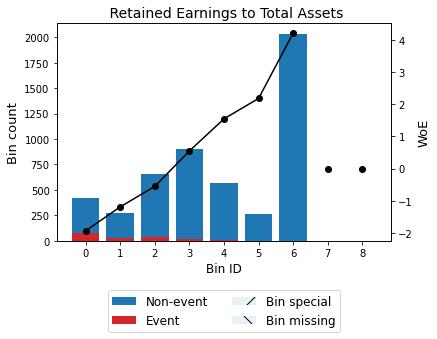

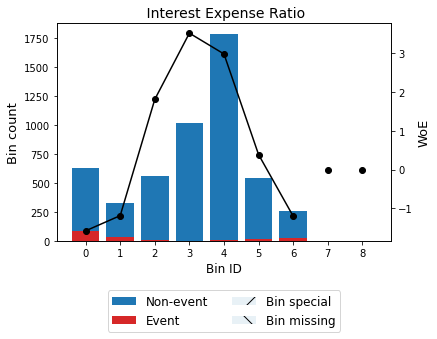

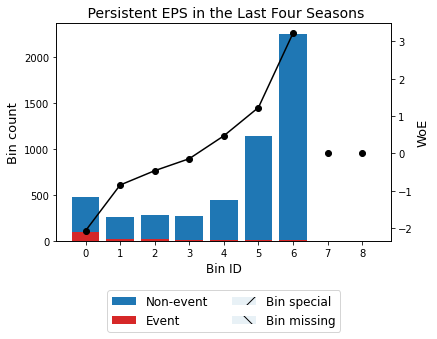

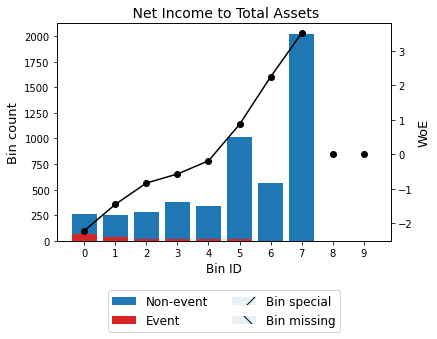

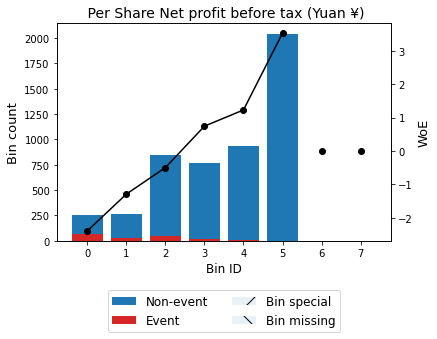

In [29]:
# 상위 5개만 다시 플롯팅

for i, row in Df_IV.iterrows():
  col = row["column_name"]
  
  
  bin_x = Train_X[col].values

  optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
  optb.fit(bin_x, Train_Y)


  binning_table = optb.binning_table
  binning_table.build()

  binning_table.plot(metric="woe")

  if i>3 : break

3. Modeliing

In [30]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, max_iter=1000).fit(Train_X_B, Train_Y)
print(clf.score(Test_X_B, Test_Y))

0.967741935483871


In [31]:
y_pred = clf.predict_proba(Test_X_B)[:, 1]

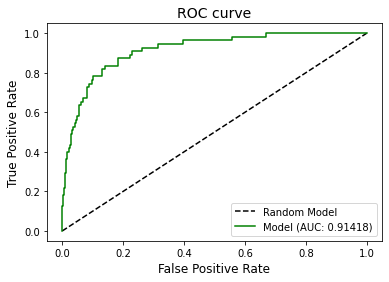

In [32]:
plot_auc_roc(Test_Y, y_pred)

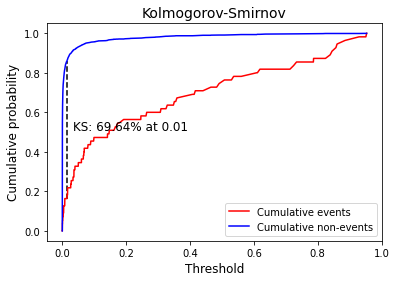

In [33]:
plot_ks(Test_Y, y_pred)

4. Feature Selection(lasso : (least absolute shrinkage and selection operator)

In [34]:
from sklearn.svm import l1_min_c

cs = l1_min_c(Train_X, Train_Y, loss='log') * np.logspace(0, 7, 16)
cs = []

for i in range(1,20):
  cs.append(i/100)

In [35]:
for i in range(1,20):
  cs.append(i/100)

cs

[0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19]

In [36]:
for i in range(1,20):
  cs.append(i/100)

C :  0.01 10 개의 feature가 선택되었습니다.


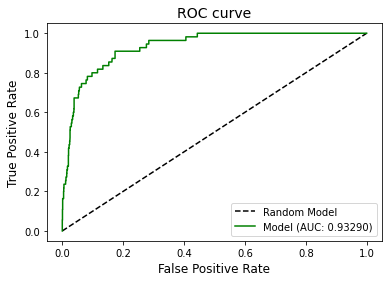

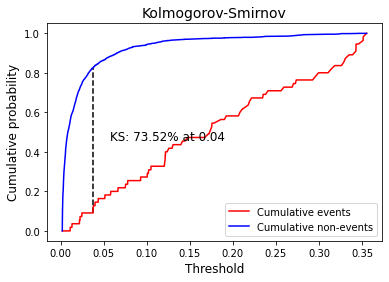

C :  0.02 13 개의 feature가 선택되었습니다.


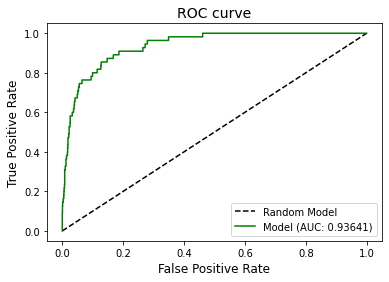

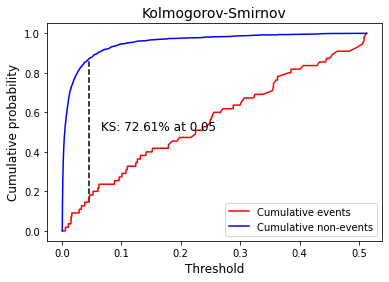

C :  0.03 15 개의 feature가 선택되었습니다.


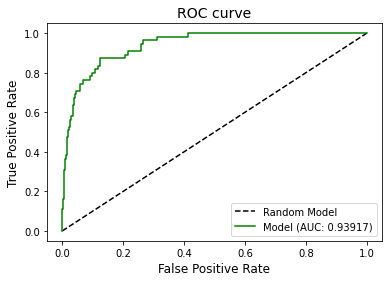

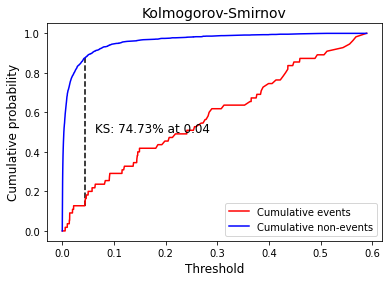

C :  0.04 16 개의 feature가 선택되었습니다.


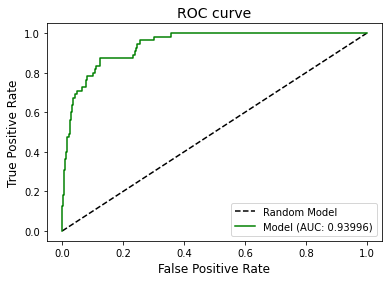

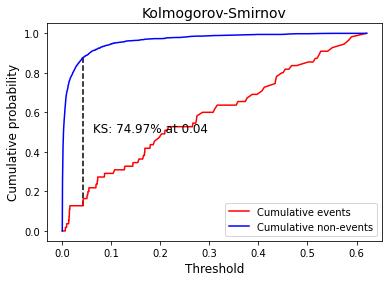

C :  0.05 18 개의 feature가 선택되었습니다.


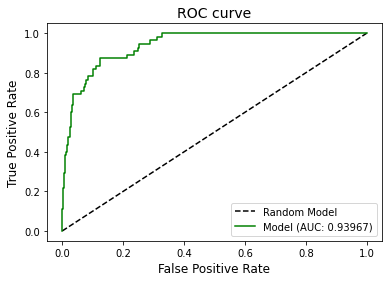

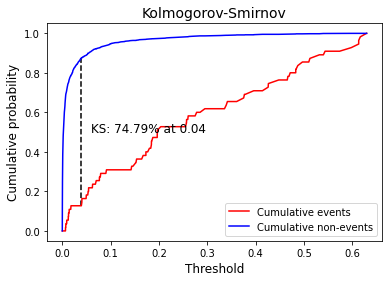

C :  0.06 17 개의 feature가 선택되었습니다.


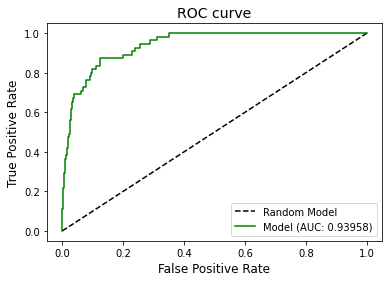

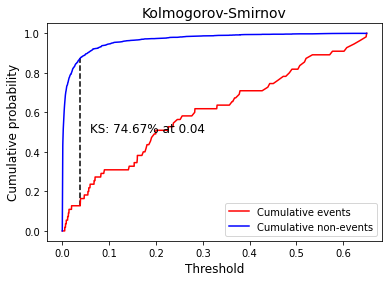

C :  0.07 22 개의 feature가 선택되었습니다.


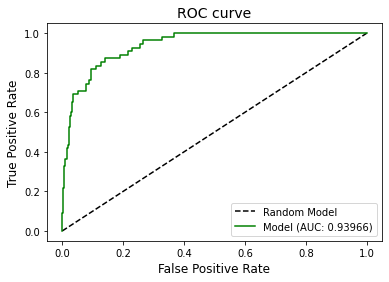

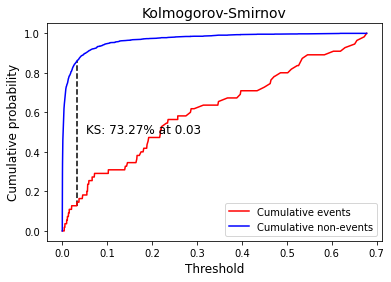

C :  0.08 25 개의 feature가 선택되었습니다.


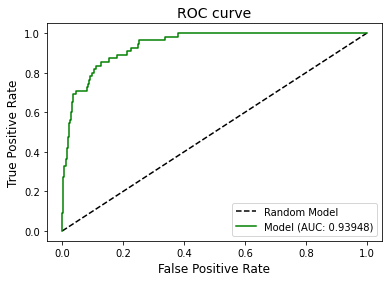

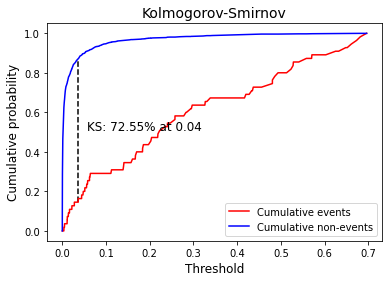

C :  0.09 25 개의 feature가 선택되었습니다.


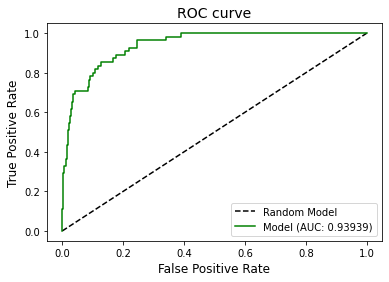

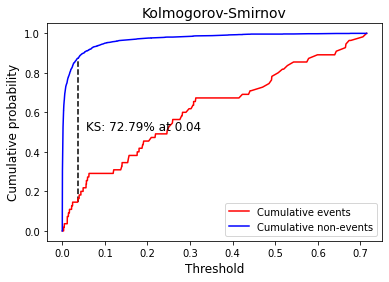

C :  0.1 28 개의 feature가 선택되었습니다.


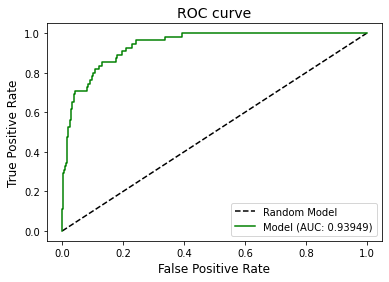

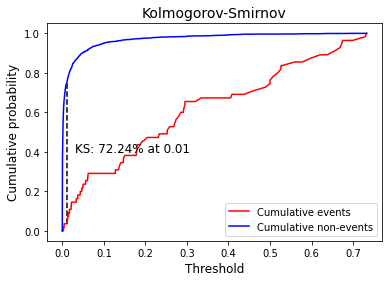

C :  0.11 31 개의 feature가 선택되었습니다.


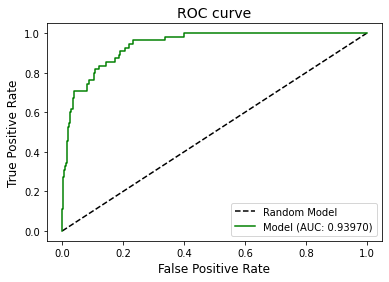

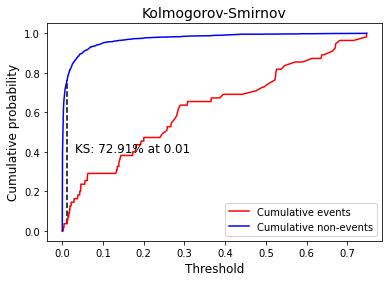

C :  0.12 31 개의 feature가 선택되었습니다.


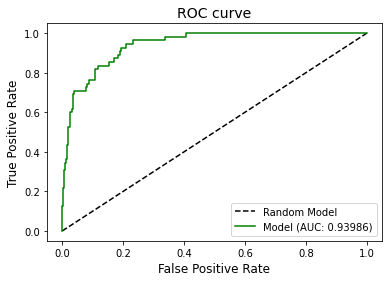

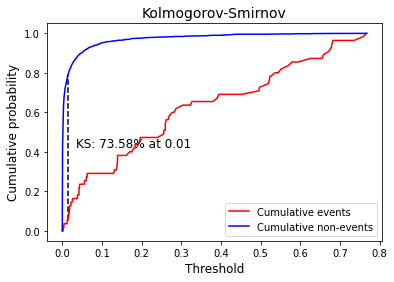

C :  0.13 35 개의 feature가 선택되었습니다.


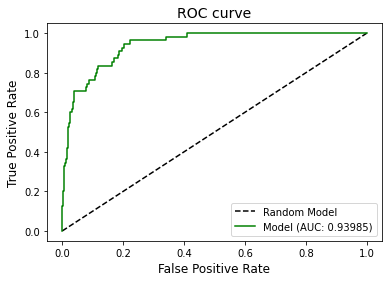

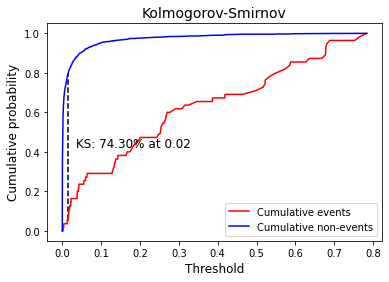

C :  0.14 37 개의 feature가 선택되었습니다.


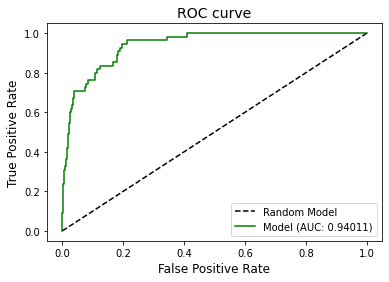

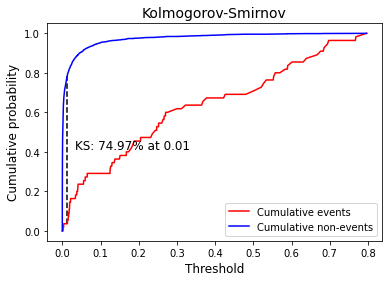

C :  0.15 39 개의 feature가 선택되었습니다.


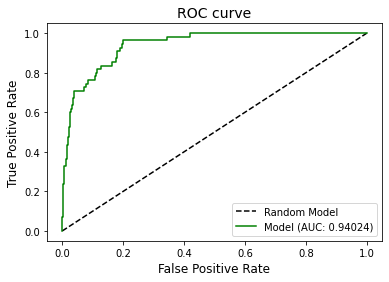

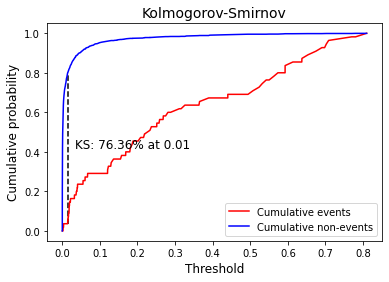

C :  0.16 43 개의 feature가 선택되었습니다.


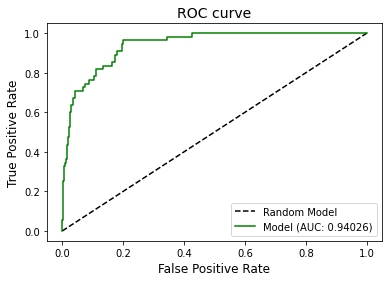

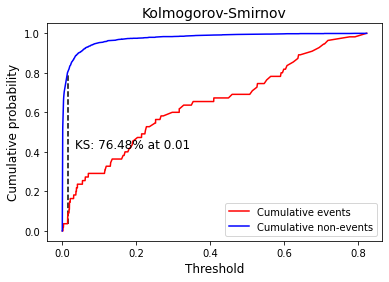

C :  0.17 43 개의 feature가 선택되었습니다.


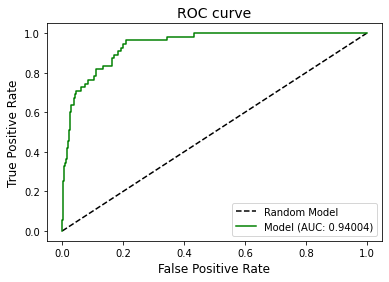

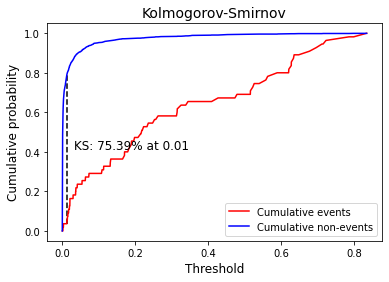

C :  0.18 46 개의 feature가 선택되었습니다.


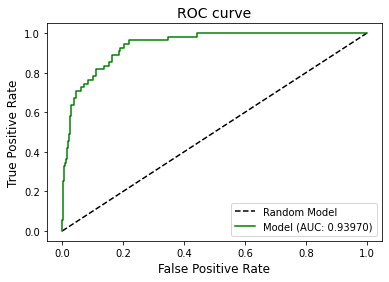

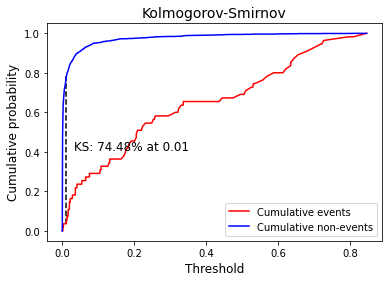

C :  0.19 47 개의 feature가 선택되었습니다.


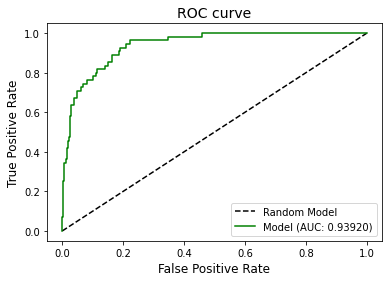

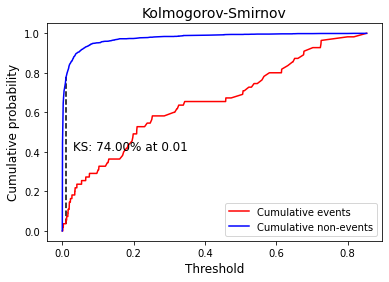

C :  0.01 10 개의 feature가 선택되었습니다.


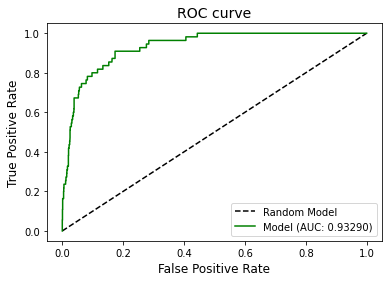

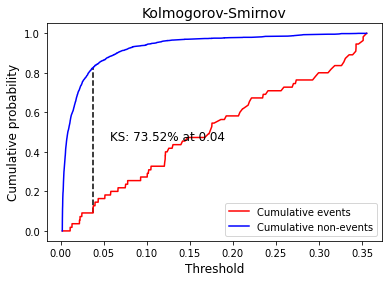

C :  0.02 13 개의 feature가 선택되었습니다.


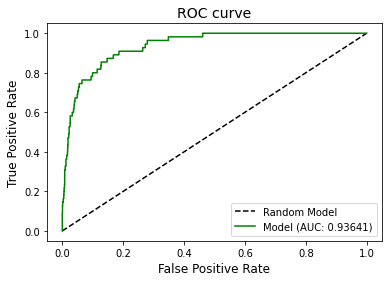

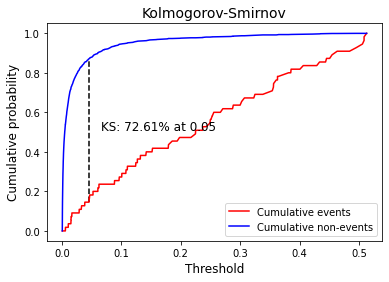

C :  0.03 15 개의 feature가 선택되었습니다.


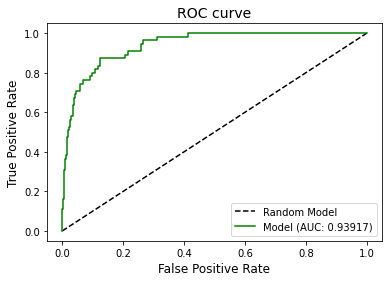

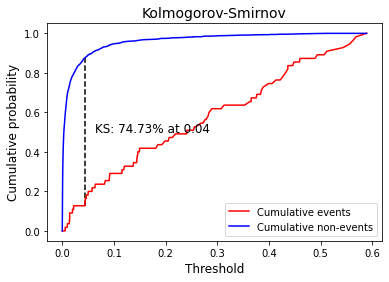

C :  0.04 16 개의 feature가 선택되었습니다.


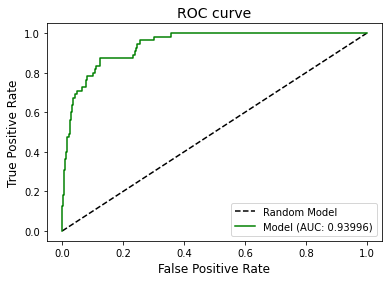

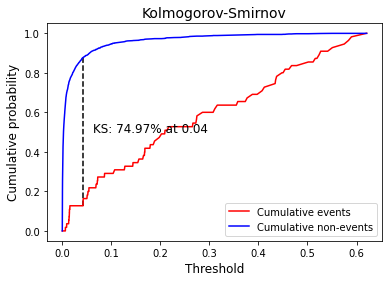

C :  0.05 18 개의 feature가 선택되었습니다.


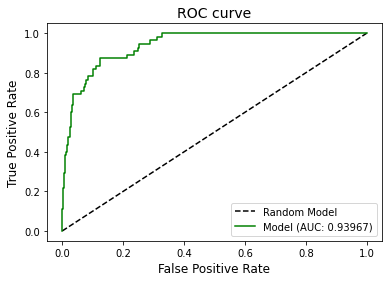

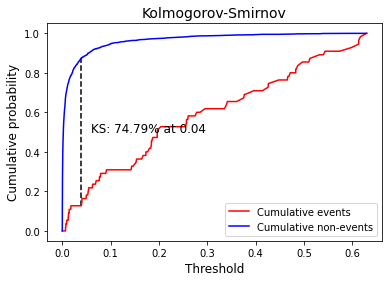

C :  0.06 17 개의 feature가 선택되었습니다.


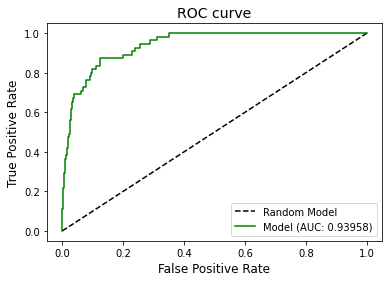

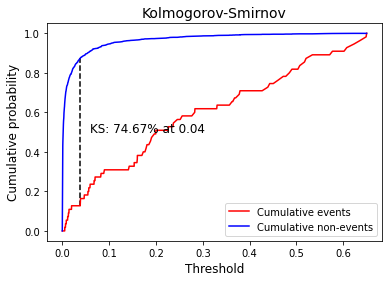

C :  0.07 22 개의 feature가 선택되었습니다.


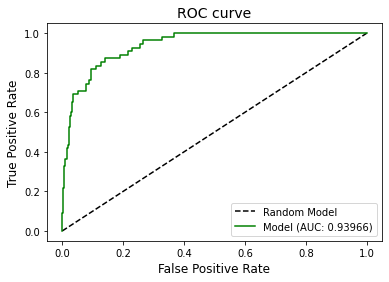

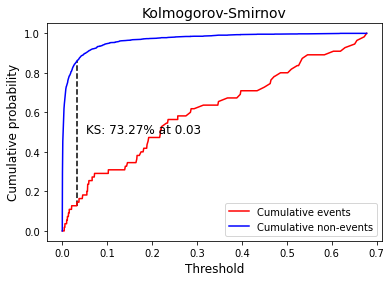

C :  0.08 25 개의 feature가 선택되었습니다.


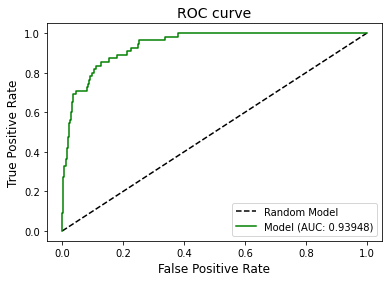

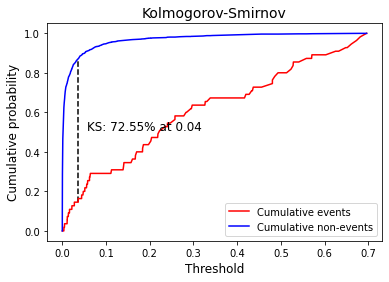

C :  0.09 25 개의 feature가 선택되었습니다.


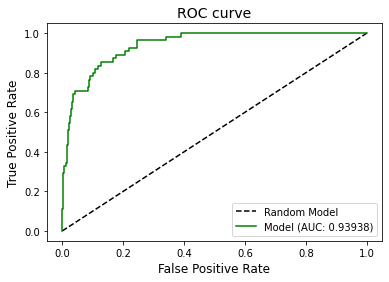

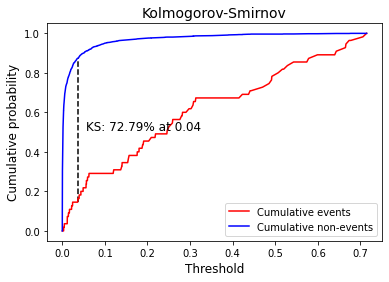

C :  0.1 28 개의 feature가 선택되었습니다.


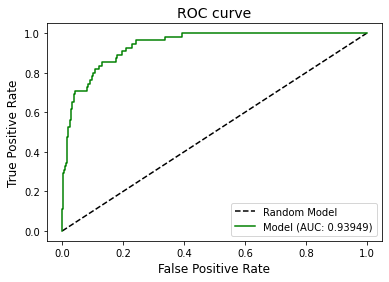

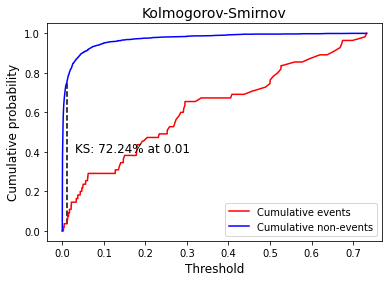

C :  0.11 31 개의 feature가 선택되었습니다.


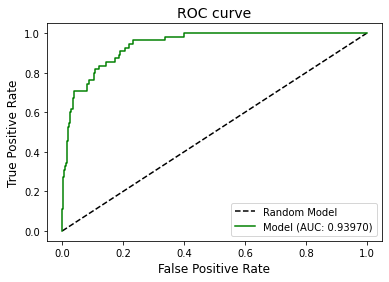

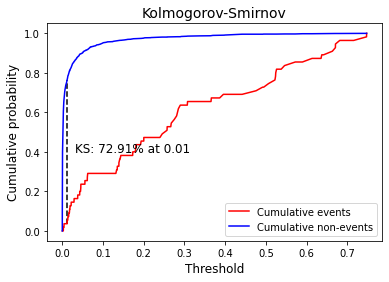

C :  0.12 31 개의 feature가 선택되었습니다.


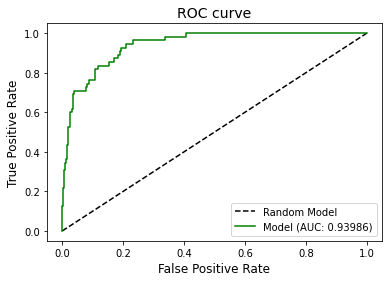

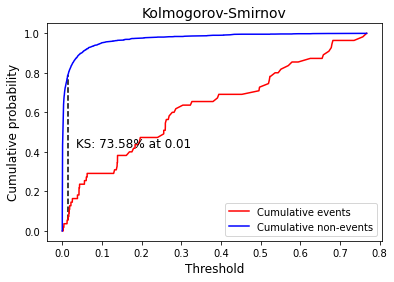

C :  0.13 35 개의 feature가 선택되었습니다.


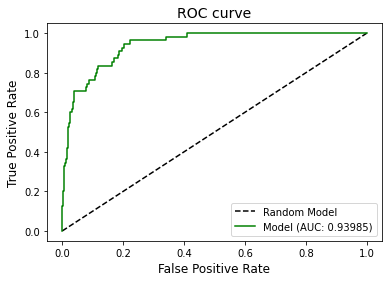

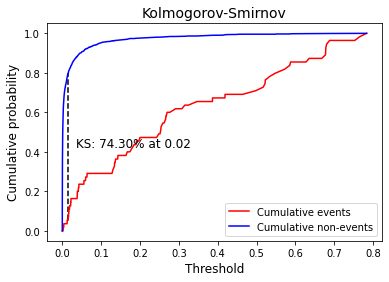

C :  0.14 37 개의 feature가 선택되었습니다.


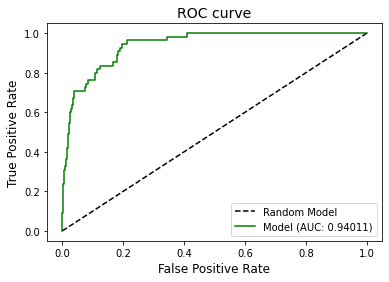

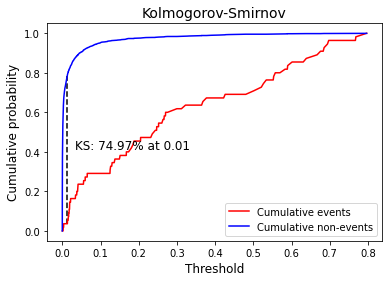

C :  0.15 39 개의 feature가 선택되었습니다.


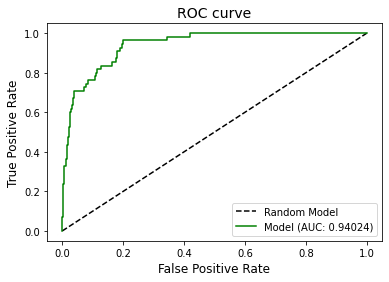

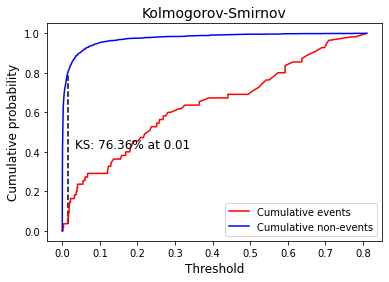

C :  0.16 43 개의 feature가 선택되었습니다.


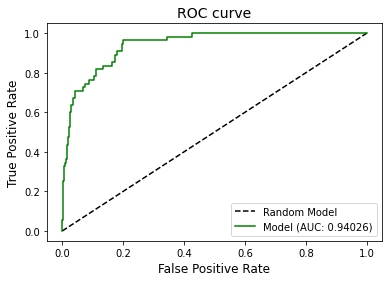

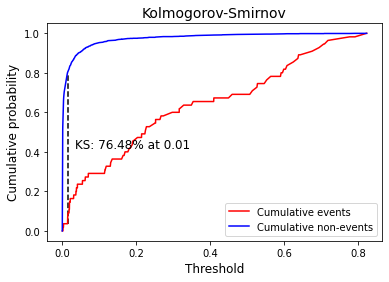

C :  0.17 43 개의 feature가 선택되었습니다.


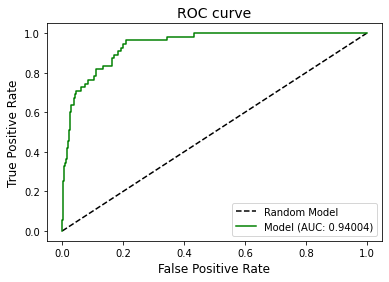

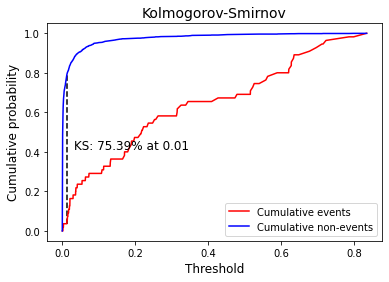

C :  0.18 46 개의 feature가 선택되었습니다.


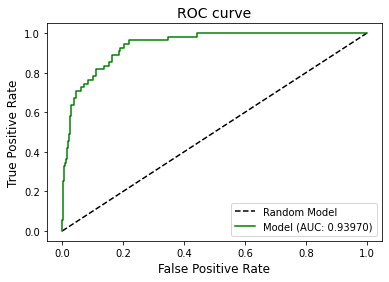

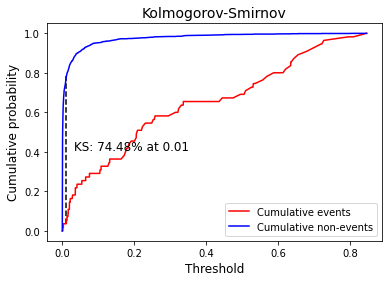

C :  0.19 47 개의 feature가 선택되었습니다.


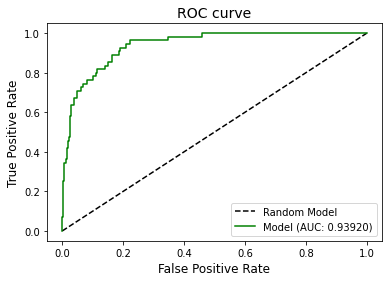

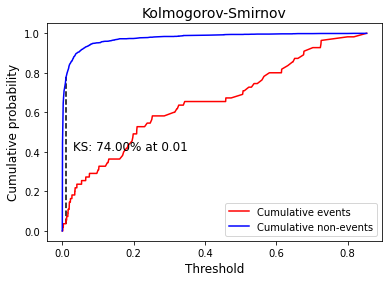

C :  0.01 10 개의 feature가 선택되었습니다.


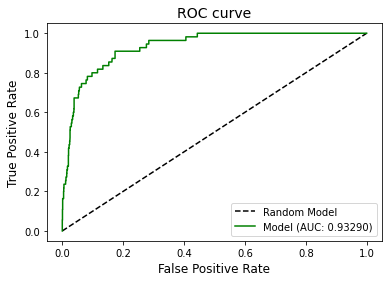

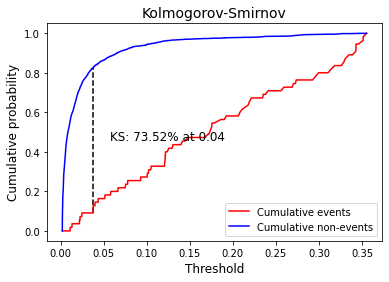

C :  0.02 13 개의 feature가 선택되었습니다.


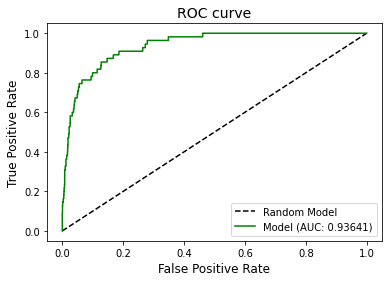

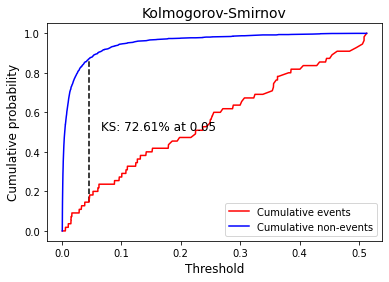

C :  0.03 15 개의 feature가 선택되었습니다.


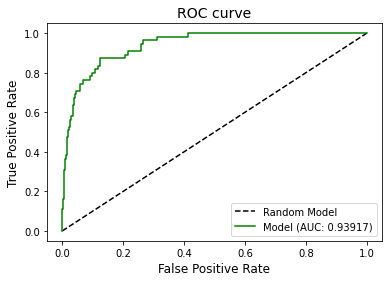

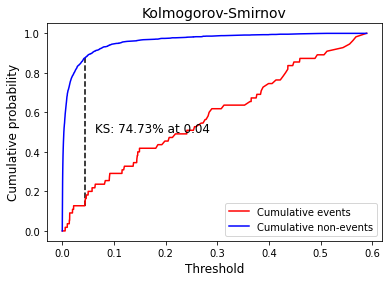

C :  0.04 16 개의 feature가 선택되었습니다.


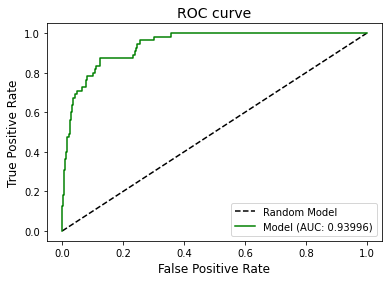

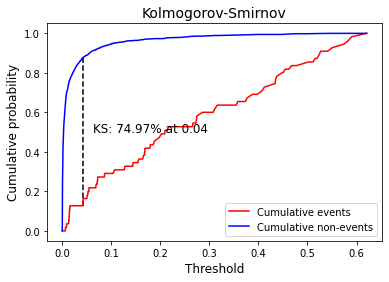

C :  0.05 18 개의 feature가 선택되었습니다.


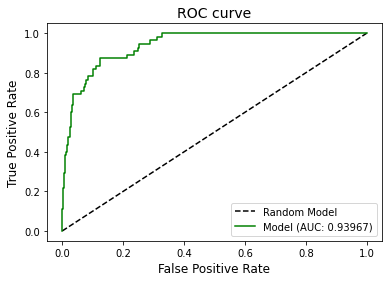

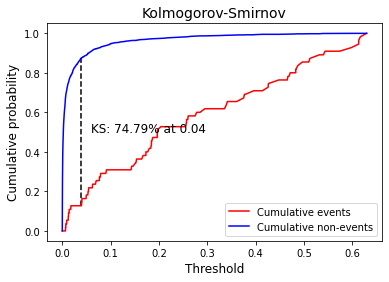

C :  0.06 17 개의 feature가 선택되었습니다.


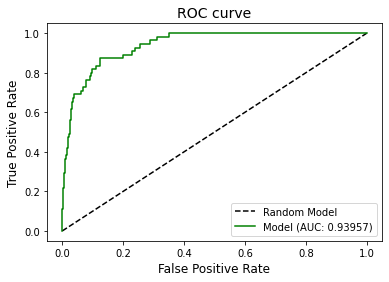

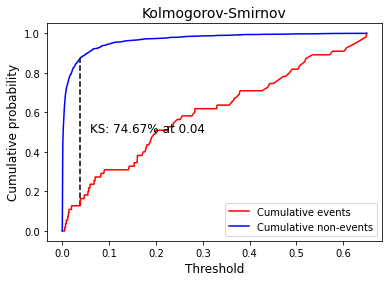

C :  0.07 22 개의 feature가 선택되었습니다.


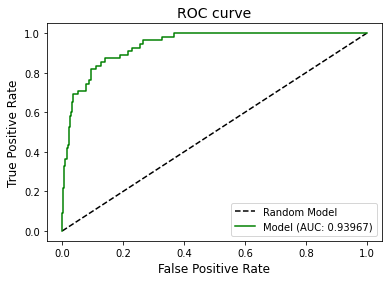

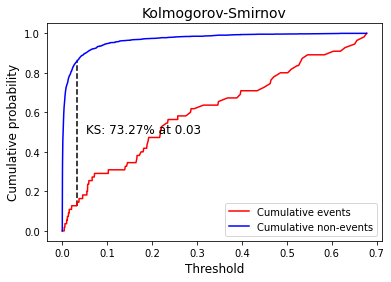

C :  0.08 25 개의 feature가 선택되었습니다.


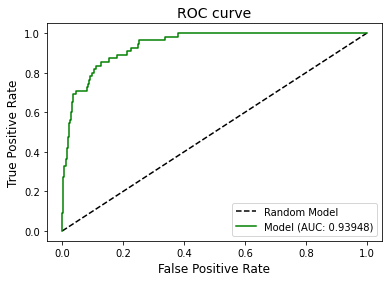

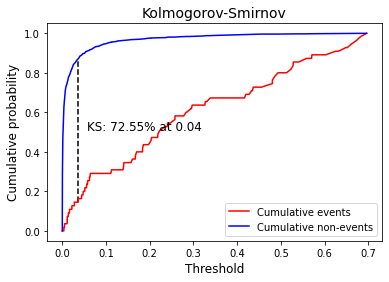

C :  0.09 25 개의 feature가 선택되었습니다.


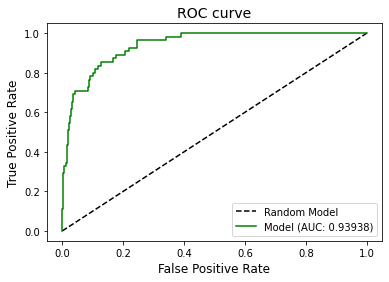

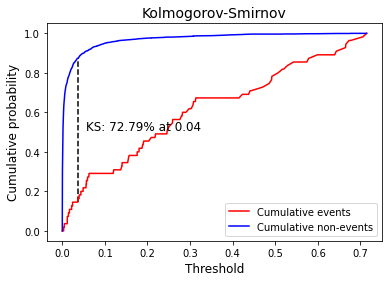

C :  0.1 28 개의 feature가 선택되었습니다.


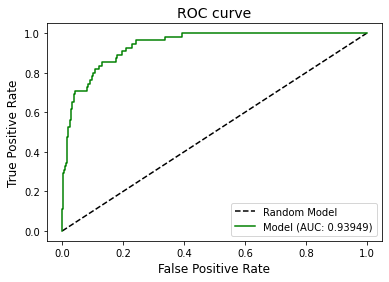

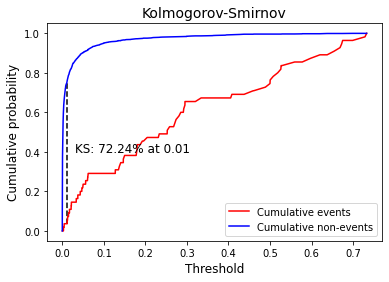

C :  0.11 31 개의 feature가 선택되었습니다.


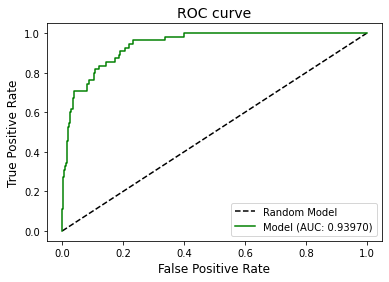

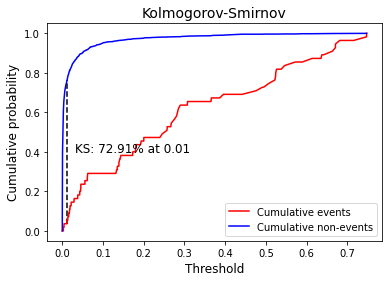

C :  0.12 31 개의 feature가 선택되었습니다.


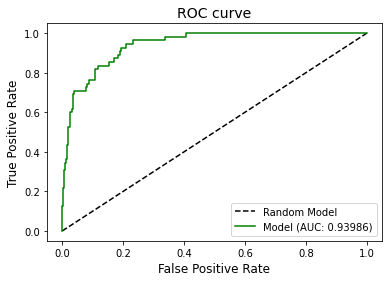

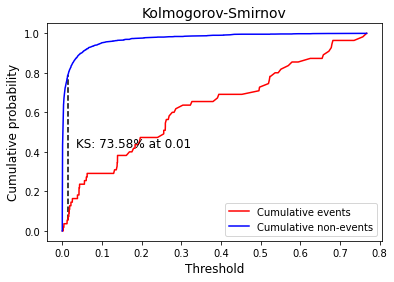

C :  0.13 35 개의 feature가 선택되었습니다.


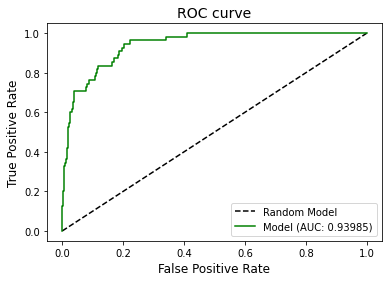

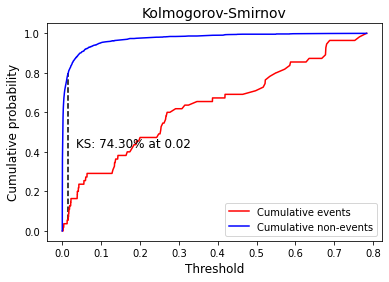

C :  0.14 37 개의 feature가 선택되었습니다.


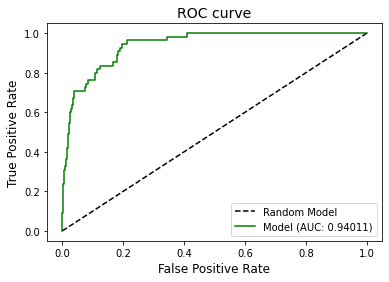

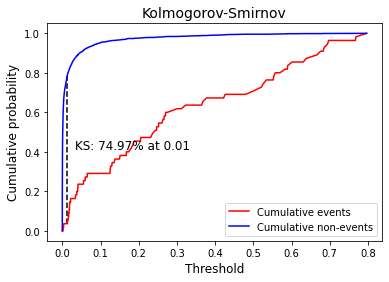

C :  0.15 39 개의 feature가 선택되었습니다.


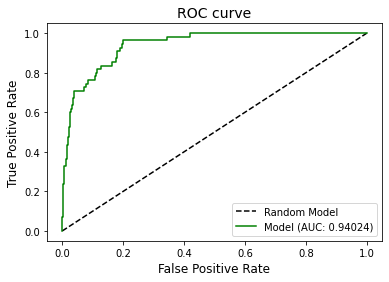

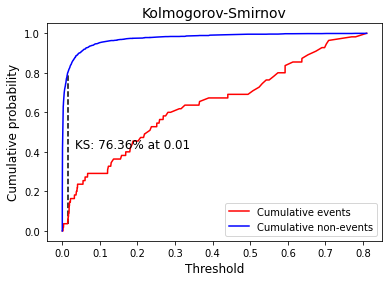

C :  0.16 43 개의 feature가 선택되었습니다.


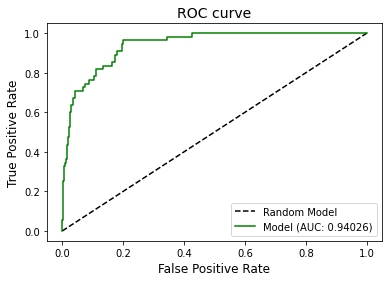

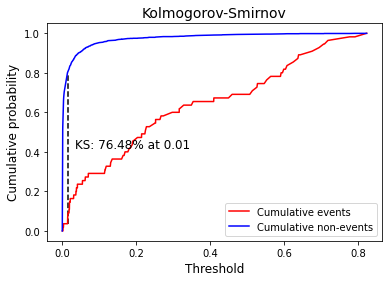

C :  0.17 43 개의 feature가 선택되었습니다.


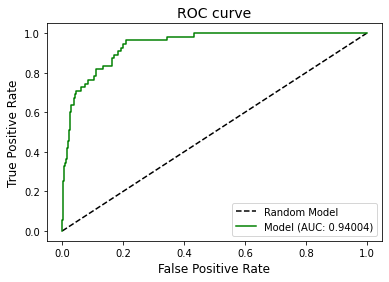

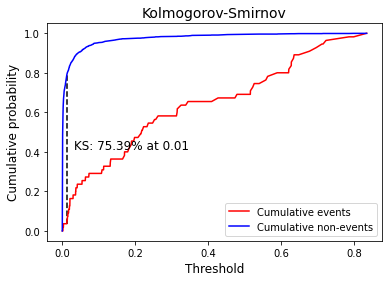

C :  0.18 46 개의 feature가 선택되었습니다.


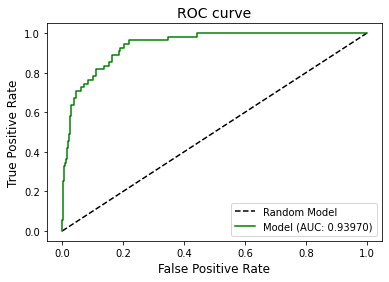

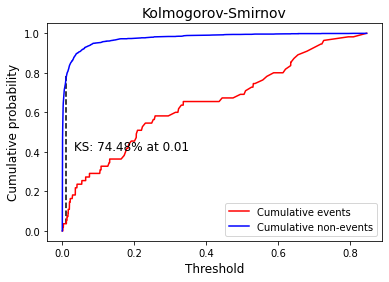

C :  0.19 47 개의 feature가 선택되었습니다.


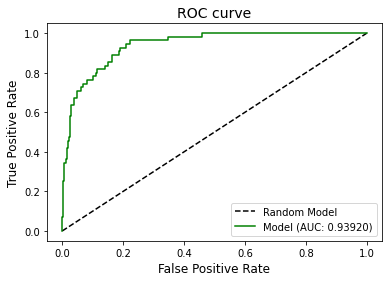

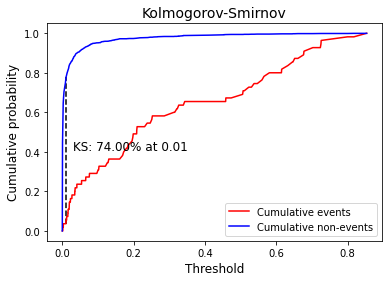

In [37]:
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(Train_X_B, Train_Y)
    coefs_.append(clf.coef_.ravel().copy())
    coef = clf.coef_.reshape(-1)

    i_cnt = 0
    for i, w in sorted(enumerate(coef), key=lambda x:-abs(x[1])):
      if w == 0 : break
      i_cnt +=1
    print("C : ",c, i_cnt, "개의 feature가 선택되었습니다.")
    y_pred = clf.predict_proba(Test_X_B)[:, 1]
    plot_auc_roc(Test_Y, y_pred)
    plt.show()
    plot_ks(Test_Y, y_pred)
    plt.show()

In [38]:
columns = Train_X.columns
columns[np.where(coef !=0)]

Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(B) before interest and depreciation after tax',
       ' Realized Sales Gross Margin', ' Operating Profit Rate',
       ' Pre-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Operating Expense Rate', ' Research and development expense rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Regular Net Profit Growth Rate', ' Continuous Net Profit Growth Rate',
       ' Total Asset Growth Rate', ' Net Value Growth Rate',
       ' Cash Reinvestment %', ' Quick Ratio', ' Interest Expense Ratio',
       ' Total debt/Total net worth', ' Borrowing dependency',
       ' Contingent liabilities/Net worth',
       ' Operating profit/Paid-in capital', ' Average Collection Days',
       ' Inventory Turnover Rate (times)

4. Feature Selection(using IV)

In [39]:
#IV기준 상위 24개 추출
fin_col  = []
for i, row in Df_IV.iterrows():
  fin_col.append(row["column_name"])
  if i>21 : break

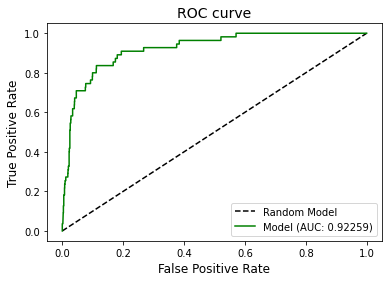

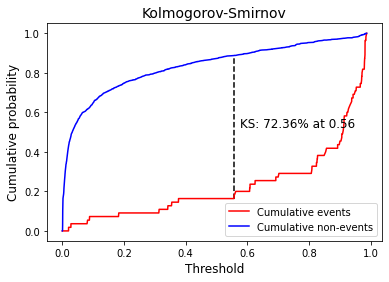

In [40]:
from sklearn.linear_model import LogisticRegression
fin_clf = LogisticRegression(random_state=42, class_weight="balanced").fit(Train_X_B[fin_col], Train_Y)


y_pred = fin_clf.predict_proba(Test_X_B[fin_col])[:, 1]
plot_auc_roc(Test_Y, y_pred)
plt.show()
plot_ks(Test_Y, y_pred)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFECV, SelectKBest, f_classif

# Set RandomForestClassifier as estimator for RFECV
cart = RandomForestClassifier(random_state=42)
# Minimum number of features to consider
min_features_to_select = 1  
# Set number of folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1) 
# Set cross-validation process
rfecv = RFECV(estimator=cart, step=1, cv=cv,
              scoring='accuracy',
              min_features_to_select=min_features_to_select, n_jobs=1)
# Fit the model
rfecv.fit(Train_X, Train_Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [ ]:
# Display features' names
most_relevent_cols = df.iloc[:, 1:].columns[np.where(rfecv.support_ == True)]
print("Most relevant features are: ")
print(most_relevent_cols)

Most relevant features are: 
Index([' ROA(C) before interest and depreciation before interest',
       ' Non-industry income and expenditure/revenue',
       ' Interest-bearing debt interest rate', ' Net Value Per Share (B)',
       ' Net Value Per Share (A)', ' Persistent EPS in the Last Four Seasons',
       ' Net Value Growth Rate', ' Total Asset Return Growth Rate Ratio',
       ' Quick Ratio', ' Interest Expense Ratio',
       ' Total debt/Total net worth', ' Debt ratio %', ' Borrowing dependency',
       ' Net profit before tax/Paid-in capital',
       ' Accounts Receivable Turnover', ' Fixed Assets Turnover Frequency',
       ' Cash/Total Assets', ' Cash/Current Liability',
       ' Inventory/Working Capital', ' Working Capital/Equity',
       ' Net Income to Total Assets', ' No-credit Interval',
       ' Net Income to Stockholder's Equity',
       ' Degree of Financial Leverage (DFL)',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Equity to Liability'],

In [ ]:
# Append target
lst_most_relevent_cols = list(most_relevent_cols)

In [ ]:
lst_most_relevent_cols.sort()
lst_most_relevent_cols

[' Accounts Receivable Turnover',
 ' Borrowing dependency',
 ' Cash/Current Liability',
 ' Cash/Total Assets',
 ' Debt ratio %',
 ' Degree of Financial Leverage (DFL)',
 ' Equity to Liability',
 ' Fixed Assets Turnover Frequency',
 ' Interest Coverage Ratio (Interest expense to EBIT)',
 ' Interest Expense Ratio',
 ' Interest-bearing debt interest rate',
 ' Inventory/Working Capital',
 " Net Income to Stockholder's Equity",
 ' Net Income to Total Assets',
 ' Net Value Growth Rate',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (B)',
 ' Net profit before tax/Paid-in capital',
 ' No-credit Interval',
 ' Non-industry income and expenditure/revenue',
 ' Persistent EPS in the Last Four Seasons',
 ' Quick Ratio',
 ' ROA(C) before interest and depreciation before interest',
 ' Total Asset Return Growth Rate Ratio',
 ' Total debt/Total net worth',
 ' Working Capital/Equity']

In [ ]:
lst_most_relevent_cols = [' Accounts Receivable Turnover',
 ' Borrowing dependency',
 ' Cash/Current Liability',
 ' Cash/Total Assets',
 ' Debt ratio %',
 ' Degree of Financial Leverage (DFL)',
 ' Equity to Liability',
 ' Fixed Assets Turnover Frequency',
 ' Interest Coverage Ratio (Interest expense to EBIT)',
 ' Interest Expense Ratio',
 ' Interest-bearing debt interest rate',
 ' Inventory/Working Capital',
 " Net Income to Stockholder's Equity",
 ' Net Income to Total Assets',
 ' Net Value Growth Rate',
 ' Net Value Per Share (A)',
 ' Net Value Per Share (B)',
 ' Net profit before tax/Paid-in capital',
 ' No-credit Interval',
 ' Non-industry income and expenditure/revenue',
 ' Persistent EPS in the Last Four Seasons',
 ' Quick Ratio',
 ' ROA(C) before interest and depreciation before interest',
 ' Total Asset Return Growth Rate Ratio',
 ' Total debt/Total net worth',
 ' Working Capital/Equity']

In [ ]:
#compare with high IV col
fin_col
fin_col.sort()
fin_col

[' After-tax net Interest Rate',
 ' Borrowing dependency',
 ' Continuous interest rate (after tax)',
 ' Debt ratio %',
 ' Degree of Financial Leverage (DFL)',
 ' Equity to Liability',
 ' Interest Coverage Ratio (Interest expense to EBIT)',
 ' Interest Expense Ratio',
 ' Liability to Equity',
 " Net Income to Stockholder's Equity",
 ' Net Income to Total Assets',
 ' Net Value Per Share (B)',
 ' Net profit before tax/Paid-in capital',
 ' Net worth/Assets',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Persistent EPS in the Last Four Seasons',
 ' Pre-tax net Interest Rate',
 ' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Retained Earnings to Total Assets',
 ' Total debt/Total net worth',
 ' Total income/Total expense']

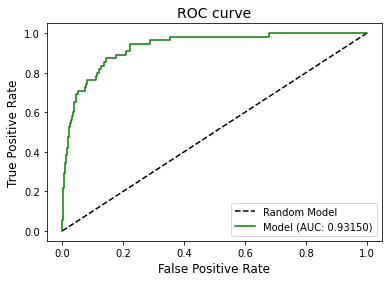

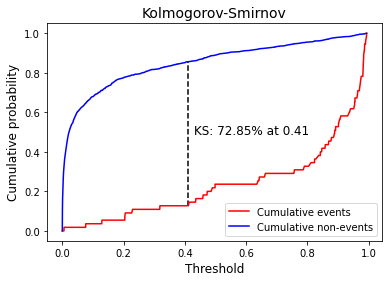

In [ ]:
from sklearn.linear_model import LogisticRegression
rfecv_clf = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000).fit(Train_X_B[lst_most_relevent_cols], Train_Y)


y_pred = rfecv_clf.predict_proba(Test_X_B[lst_most_relevent_cols])[:, 1]
plot_auc_roc(Test_Y, y_pred)
plt.show()
plot_ks(Test_Y, y_pred)
plt.show()

In [ ]:
# 학습
import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=1000, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(Train_X[lst_most_relevent_cols], Train_Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

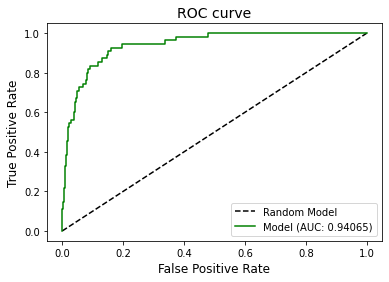

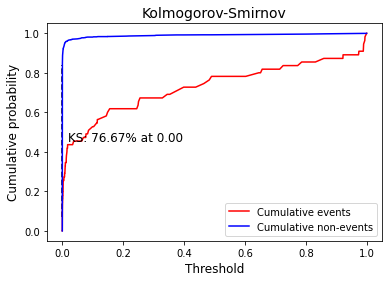

In [ ]:
y_pred = xgc.predict_proba(Test_X[lst_most_relevent_cols])[:, 1]
plot_auc_roc(Test_Y, y_pred)
plt.show()
plot_ks(Test_Y, y_pred)
plt.show()

5. Score 카드 만들기

In [ ]:
variable_names = list(df.columns[1:])

In [ ]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 1},
    "quality_score": {"min": 0.01}
}

In [ ]:
binning_process = BinningProcess(variable_names, selection_criteria=selection_criteria,categorical_variables= cate_cols )

In [ ]:
estimator = LogisticRegression(solver="lbfgs", class_weight="balanced")

In [ ]:
scorecard = Scorecard(target=target, binning_process=binning_process,
                      estimator=estimator, scaling_method="min_max",
                      scaling_method_params={"min": 300, "max": 850})

In [ ]:
scorecard.fit(df_train)

Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                         binning_transform_params=None,
                                         categorical_variables=[' '
                                                                'Liability-Assets '
                                                                'Flag',
                                                                ' Net Income '
                                                                'Flag'],
                                         max_bin_size=None, max_n_bins=None,
                                         max_n_prebins=20, max_pvalue=None,
                                         max_pvalue_policy='consecutive',
                                         min_bin_size=None, min_n_bins=None,
                                         min_prebin_size=0.05, n_jobs=None,
                                         selection_criteria={...
                                       du

In [ ]:
scorecard.information(print_level=2)

optbinning (Version 0.11.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                         Bankrupt?   * U
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   4773
    Number of variables                   95
    Target type                       binary

    Number of numerical                   93
    Number of categorical                  2
    Number of selected                    33

  Timing
    Total time                         13.28 sec
    Binning process                    13.01 sec   ( 98.02%)
    Esti

In [ ]:
scorecard.table(style="summary")

,Variable,Bin,Points
0,Research and development expense rate,"[-inf, 0.00)",12.908685
1,Research and development expense rate,"[0.00, 0.00)",30.177854
2,Research and development expense rate,"[0.00, 0.00)",24.982593
3,Research and development expense rate,"[0.00, 0.00)",19.938223
4,Research and development expense rate,"[0.00, 6649999872.00)",16.087127
5,Research and development expense rate,"[6649999872.00, inf)",15.808417
6,Research and development expense rate,Special,15.975749
7,Research and development expense rate,Missing,15.975749
0,Interest-bearing debt interest rate,"[-inf, 0.00)",31.492324
1,Interest-bearing debt interest rate,"[0.00, 0.00)",23.521333


In [ ]:
scorecard.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,Research and development expense rate,0,"[-inf, 0.00)",1005,0.210559,954,51,0.050746,-0.472143,5.884346e-02,7.287865e-03,-0.656483,12.908685
1,Research and development expense rate,1,"[0.00, 0.00)",268,0.056149,267,1,0.003731,2.186268,1.121801e-01,1.176315e-02,-0.656483,30.177854
2,Research and development expense rate,2,"[0.00, 0.00)",242,0.050702,240,2,0.008264,1.386511,5.403550e-02,6.260590e-03,-0.656483,24.982593
3,Research and development expense rate,3,"[0.00, 0.00)",281,0.058873,276,5,0.017794,0.609982,1.664376e-02,2.048805e-03,-0.656483,19.938223
4,Research and development expense rate,4,"[0.00, 6649999872.00)",2584,0.541379,2502,82,0.031734,0.017146,1.578787e-04,1.973460e-05,-0.656483,16.087127
5,Research and development expense rate,5,"[6649999872.00, inf)",393,0.082338,380,13,0.033079,-0.025759,5.529675e-05,6.911902e-06,-0.656483,15.808417
6,Research and development expense rate,6,Special,0,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.656483,15.975749
7,Research and development expense rate,7,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.656483,15.975749
0,Interest-bearing debt interest rate,0,"[-inf, 0.00)",781,0.163629,778,3,0.003841,2.157133,3.213141e-01,3.383244e-02,-0.726931,31.492324
1,Interest-bearing debt interest rate,1,"[0.00, 0.00)",693,0.145192,685,8,0.011544,1.048996,1.010734e-01,1.208500e-02,-0.726931,23.521333


In [ ]:
sc = scorecard.table(style="summary")
sc.groupby("Variable").agg({'Points' : [np.min, np.max]}).sum()

Points  amin    300.0
        amax    850.0
dtype: float64

In [ ]:
y_pred = scorecard.predict_proba(df_test)[:, 1]

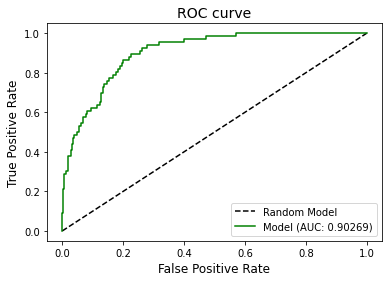

In [ ]:
plot_auc_roc(df_test[target], y_pred)

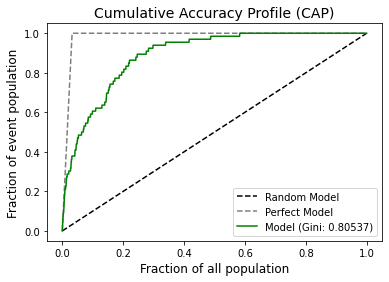

In [ ]:
plot_cap(df_test[target], y_pred)

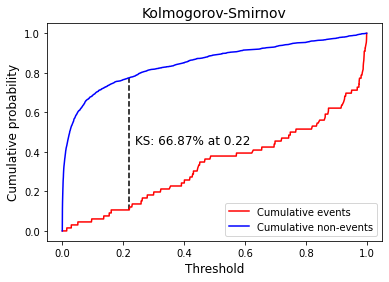

In [ ]:
plot_ks(df_test[target], y_pred)

In [ ]:
score = scorecard.score(df_test)

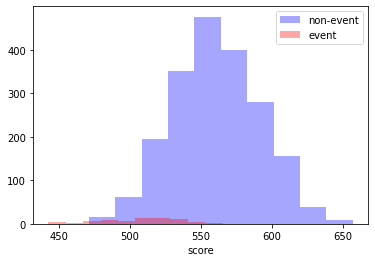

In [ ]:
mask = df_test[target] == 0
plt.hist(score[mask], label="non-event", color="b", alpha=0.35)
plt.hist(score[~mask], label="event", color="r", alpha=0.35)
plt.xlabel("score")
plt.legend()
plt.show()

6.Score 카드 모니터링 :  Population Stability Index (PSI)

In [ ]:
from optbinning.scorecard import ScorecardMonitoring
monitoring = ScorecardMonitoring(target=target, scorecard=scorecard, psi_method="cart",
                                 psi_n_bins=10, verbose=True)

In [ ]:
monitoring.fit(df_test, df_train)

2021-08-27 01:17:16,984 | INFO : Monitoring started.
2021-08-27 01:17:16,987 | INFO : Options: check parameters.
2021-08-27 01:17:16,990 | INFO : System stability analysis started.
2021-08-27 01:17:17,210 | INFO : System stability analysis terminated. Time: 0.2172s
2021-08-27 01:17:17,212 | INFO : Variable analysis started.
2021-08-27 01:17:17,352 | INFO : Variable analysis terminated. Time: 0.1306s
2021-08-27 01:17:17,355 | INFO : Monitoring terminated. Time: 0.3713s


ScorecardMonitoring(psi_method='cart', psi_min_bin_size=0.05, psi_n_bins=10,
                    scorecard=Scorecard(binning_process=BinningProcess(binning_fit_params=None,
                                                                       binning_transform_params=None,
                                                                       categorical_variables=[' '
                                                                                              'Liability-Assets '
                                                                                              'Flag',
                                                                                              ' '
                                                                                              'Net '
                                                                                              'Income '
                                                                                              'Flag'],
     

In [ ]:
monitoring.information(print_level=2)

optbinning (Version 0.11.0)
Copyright (c) 2019-2021 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    target                         Bankrupt?   * U
    scorecard                            yes   * U
    psi_method                          cart   * d
    psi_n_bins                            10   * U
    psi_min_bin_size                    0.05   * d
    show_digits                            2   * d
    verbose                             True   * U
  End options

  Statistics
    Number of records Actual            2046
    Number of records Expected          4773
    Number of scorecard variables         33
    Target type                       binary

  Timing
    Total time                          0.37 sec
    System stability                    0.22 sec   ( 58.48%)
    Variables stability                 0.13 sec   ( 35.18%)



In [ ]:
monitoring.psi_table()

,Bin,Count A,Count E,Count A (%),Count E (%),PSI
0,"[-inf, 506.12)",98,276,0.047898,0.057825,0.001870
1,"[506.12, 519.25)",108,299,0.052786,0.062644,0.001688
2,"[519.25, 531.08)",196,365,0.095797,0.076472,0.004354
3,"[531.08, 541.15)",195,430,0.095308,0.090090,0.000294
4,"[541.15, 556.77)",374,897,0.182796,0.187932,0.000142
5,"[556.77, 560.53)",99,239,0.048387,0.050073,0.000058
6,"[560.53, inf)",976,2267,0.477028,0.474963,0.000009
Totals,,2046,4773,1.000000,1.000000,0.008414


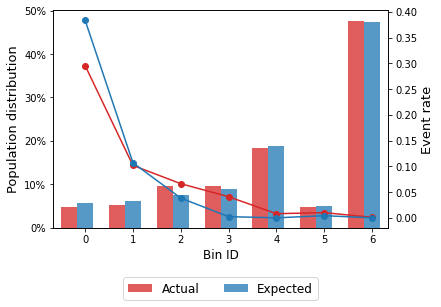

In [ ]:
monitoring.psi_plot()

In [ ]:
monitoring.tests_table()

,Bin,Count A,Count E,Event rate A,Event rate E,statistic,p-value
0,"[-inf, 506.12)",98,276,0.295918,0.384058,2.435663,0.118604
1,"[506.12, 519.25)",108,299,0.101852,0.107023,0.022458,0.880876
2,"[519.25, 531.08)",196,365,0.066327,0.038356,2.177725,0.140021
3,"[531.08, 541.15)",195,430,0.041026,0.002326,14.157388,0.000168
4,"[541.15, 556.77)",374,897,0.008021,0.000000,7.212210,0.007241
5,"[556.77, 560.53)",99,239,0.010101,0.004184,0.416649,0.518614
6,"[560.53, inf)",976,2267,0.001025,0.000000,2.323462,0.127436


In [ ]:
monitoring.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0084 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)      7        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      2   0.285714
    [0.05, 0.10)      0   0.000000
    [0.10, 0.50)      3   0.428571
    [0.50, 1.00)      2   0.285714

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records    2046          -      4773            -
        Event records      66  0.0322581       154    0.0322648
    Non-event records    1980   0.967742      4619     0.967735

  Performance metrics

                 Metric    Actual  Expected  Diff A - E
     True positive rate  0.621212  0.915584   -0.294372
     True negative rate  0.